In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [3]:
bureau = pd.read_csv('bureau.csv')
train = pd.read_csv('app_train_p1.csv', index_col=0)

## Homework 6. part 2.
### Feature engineering continuation, bureau.csv

In [5]:
bureau.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [7]:
bureau['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64

In [9]:
bureau_status = pd.get_dummies(bureau, columns=['CREDIT_ACTIVE'], dtype='int')

In [11]:
bureau_status = bureau_status[['SK_ID_CURR', 'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold']]

In [13]:
bureau_status_sum = bureau_status.groupby('SK_ID_CURR').sum().reset_index()

In [15]:
bureau_status_sum

,SK_ID_CURR,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold
0,100001,3,0,4,0
1,100002,2,0,6,0
2,100003,1,0,3,0
3,100004,0,0,2,0
4,100005,2,0,1,0
...,...,...,...,...,...
305806,456249,2,0,11,0
305807,456250,2,0,1,0
305808,456253,2,0,2,0
305809,456254,0,0,1,0


In [17]:
train = train.merge(bureau_status_sum, on='SK_ID_CURR', how='left')

In [19]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-3999.0,7.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,-3264.0,0.0,NaN,NaN,NaN,0.0,1.0,0.0,3.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,-1064.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,2.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,-783.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0


In [21]:
train[['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold']].isna().mean()

CREDIT_ACTIVE_Active      0.143149
CREDIT_ACTIVE_Bad debt    0.143149
CREDIT_ACTIVE_Closed      0.143149
CREDIT_ACTIVE_Sold        0.143149
dtype: float64

In [23]:
train[['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold']]= train[['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 
                                                              'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold']].fillna(0)

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


X = train.drop(columns = ['TARGET'])
y = train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make the model with the specified regularization parameter
logr = LogisticRegression()

# Train on the training data
logr.fit(X_train, y_train)

pred_proba = logr.predict_proba(X_test)[:, 1]

### ROC AUC score, dataset_2

In [31]:
roc_auc_score(y_test, pred_proba)

0.747801516296455

In [33]:
weights = pd.DataFrame({'feature': X.columns, 'weight': logr.coef_[0]}).sort_values(by='weight', ascending=False)
weights.tail(20)

,feature,weight
206,ORGANIZATION_TYPE_Security Ministries,-0.529322
15,FLAG_MOBIL,-0.546677
296,bureau_AMT_ANNUITY_count,-0.586629
104,AMT_REQ_CREDIT_BUREAU_WEEK,-0.597096
285,bureau_AMT_CREDIT_SUM_LIMIT_sum,-0.614401
261,bureau_AMT_CREDIT_MAX_OVERDUE_count,-0.658842
119,NAME_INCOME_TYPE_Pensioner,-0.695114
182,ORGANIZATION_TYPE_Industry: type 12,-0.705169
105,AMT_REQ_CREDIT_BUREAU_MON,-0.726852
95,FLAG_DOCUMENT_15,-0.779042


In [35]:
weights.head(20)

,feature,weight
7,AMT_ANNUITY,2.621599
301,CREDIT_ACTIVE_Active,2.049814
80,DEF_60_CNT_SOCIAL_CIRCLE,1.785426
78,DEF_30_CNT_SOCIAL_CIRCLE,1.684149
6,AMT_CREDIT,1.214083
260,bureau_DAYS_ENDDATE_FACT_sum,1.197512
11,DAYS_EMPLOYED,1.096293
255,bureau_DAYS_CREDIT_ENDDATE_sum,0.983895
23,REGION_RATING_CLIENT_W_CITY,0.781545
291,bureau_DAYS_CREDIT_UPDATE_count,0.779737


 ### Feature engineering, previous_application.csv

In [37]:
prev_app = pd.read_csv('previous_application.csv')

In [39]:
prev_app.shape

(1670214, 37)

In [41]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# share of na
prev_app.isnull().mean().sort_values(ascending=False).head(20).round(3)

RATE_INTEREST_PRIVILEGED     0.996
RATE_INTEREST_PRIMARY        0.996
AMT_DOWN_PAYMENT             0.536
RATE_DOWN_PAYMENT            0.536
NAME_TYPE_SUITE              0.491
NFLAG_INSURED_ON_APPROVAL    0.403
DAYS_TERMINATION             0.403
DAYS_LAST_DUE                0.403
DAYS_LAST_DUE_1ST_VERSION    0.403
DAYS_FIRST_DUE               0.403
DAYS_FIRST_DRAWING           0.403
AMT_GOODS_PRICE              0.231
AMT_ANNUITY                  0.223
CNT_PAYMENT                  0.223
PRODUCT_COMBINATION          0.000
AMT_CREDIT                   0.000
NAME_YIELD_GROUP             0.000
NAME_PORTFOLIO               0.000
NAME_SELLER_INDUSTRY         0.000
SELLERPLACE_AREA             0.000
dtype: float64

In [45]:
# drop columns with na share > 40%
prev_app.drop(prev_app.isnull().mean().sort_values(ascending=False).head(11).index, inplace=True, axis=1)

In [47]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high


In [49]:
#overview of rows where AMT_ANNUITY is na, to decide how to work with them
prev_app.loc[prev_app['AMT_ANNUITY'].isna()].head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,TUESDAY,11,Y,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,MONDAY,7,Y,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,MONDAY,15,Y,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,SATURDAY,15,Y,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash
22,1172842,302212,Cash loans,NaN,0.0,0.0,NaN,TUESDAY,9,Y,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash


In [51]:
prev_app['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

In [53]:
prev_app['AMT_ANNUITY_is'] = (prev_app['AMT_ANNUITY'].isna()).map({False: 'notna', True: 'na'})

<Axes: xlabel='NAME_CONTRACT_STATUS', ylabel='count'>

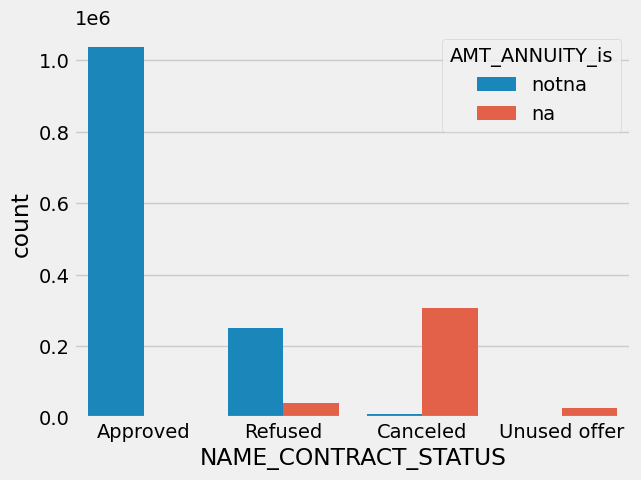

In [55]:
#countplot of contract status, comparison between rows with 'AMT_ANNUITY' na and notna
#as we can see rows that have empty values in AMT_ANNUITY column, don't have much information in other columns too.
#On countplot we can see that these rows mainly have 'canceled' status.
sns.countplot(data=prev_app, x='NAME_CONTRACT_STATUS', hue='AMT_ANNUITY_is')

In [57]:
#one hot encoding of NAME_CONTRACT_STATUS column
prev_app = pd.get_dummies(prev_app, columns=['NAME_CONTRACT_STATUS'], dtype=int)

In [59]:
prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'NAME_CASH_LOAN_PURPOSE', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT',
       'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'AMT_ANNUITY_is',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Unused offer'],
      dtype='object')

In [61]:
status_features = ['SK_ID_CURR', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Unused offer']

In [63]:
#Aggregating encoded status columns to add them to main dataset
prev_app_status = prev_app[status_features].groupby('SK_ID_CURR', as_index=False).sum()

In [65]:
#Creating column with total number of previous applications
prev_app_status['prev_app_sum'] = prev_app_status.iloc[:, 1:].sum(axis=1)

In [67]:
prev_app_status.head()

,SK_ID_CURR,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,prev_app_sum
0,100001,1,0,0,0,1
1,100002,1,0,0,0,1
2,100003,3,0,0,0,3
3,100004,1,0,0,0,1
4,100005,1,1,0,0,2


In [69]:
train = train.merge(prev_app_status, on='SK_ID_CURR', how='left')

In [71]:
X = train.drop(columns = ['TARGET'])
y = train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make the model with the specified regularization parameter
logr = LogisticRegression()

# Train on the training data
logr.fit(X_train, y_train)

pred_proba = logr.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred_proba)

0.7508886227257796

### Submission

In [74]:
test = pd.read_csv('app_test_p1.csv')
test = test.merge(bureau_status_sum, on = 'SK_ID_CURR', how = 'left')
test = test.merge(prev_app_status, on = 'SK_ID_CURR', how = 'left')
#test.to_csv('app_test_p2.csv')


train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

In [76]:
X_train = train.drop(columns = ['TARGET'])
y_train = train['TARGET']

imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

X_train = imputer.fit_transform(X_train)
test = imputer.transform(test)

X_train =scaler.fit_transform(X_train)
test = scaler.transform(test)

In [78]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [80]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [82]:
app_test = pd.read_csv('app_test.csv')
submit = pd.DataFrame(app_test['SK_ID_CURR'])
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.048707
1,100005,0.206511
2,100013,0.030336
3,100028,0.038411
4,100038,0.140855


In [84]:
submit.to_csv('hw_part2.csv', index = False)